# Value At Risk (위험 가치)

- 특정 포트폴리오가 일정기간 동안 보여준 변동률을 고려할 때 향후 발생할 수도 있는 최대 손실 가능 금액 (Worst Expected Loss)과 확률  

### APPLE 주식의 로그 수익률 분포

- histogram 으로 확인하면 normal distribution 에 매우 가깝게 나타난다.
- Mean(mu), variance(sigma) 를 historic data 로부터 추정

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
import pandas_datareader as data_reader

In [20]:
aapl = data_reader.DataReader("AAPL", data_source="yahoo")
aapl.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2017-08-07,39.730000,39.167500,39.264999,39.702499,87481200.0,37.532879
2017-08-08,40.457500,39.567501,39.650002,40.020000,144823600.0,37.833031
2017-08-09,40.317501,39.777500,39.814999,40.264999,104526000.0,38.064640
2017-08-10,40.000000,38.657501,39.974998,38.830002,163217200.0,36.852211
2017-08-11,39.642502,39.017502,39.150002,39.369999,105028400.0,37.364700


- 로그 수익률 계산

In [21]:
aapl['LogReturn'] = np.log(aapl['Adj Close']) - np.log(aapl['Adj Close'].shift(1))
aapl.head()

,High,Low,Open,Close,Volume,Adj Close,LogReturn
Date,,,,,,,
2017-08-07,39.730000,39.167500,39.264999,39.702499,87481200.0,37.532879,NaN
2017-08-08,40.457500,39.567501,39.650002,40.020000,144823600.0,37.833031,0.007965
2017-08-09,40.317501,39.777500,39.814999,40.264999,104526000.0,38.064640,0.006103
2017-08-10,40.000000,38.657501,39.974998,38.830002,163217200.0,36.852211,-0.032370
2017-08-11,39.642502,39.017502,39.150002,39.369999,105028400.0,37.364700,0.013811


<AxesSubplot:xlabel='Date'>

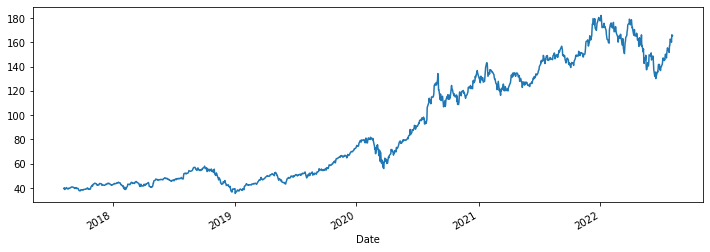

In [22]:
aapl['Close'].plot(figsize=(12, 4))

<AxesSubplot:xlabel='Date'>

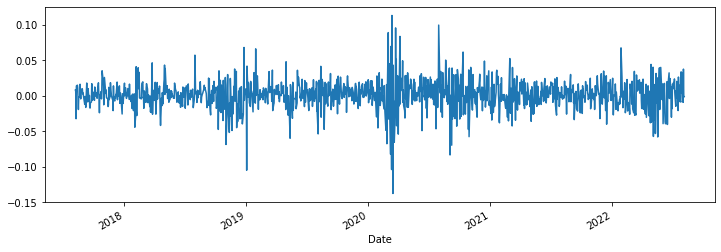

In [23]:
aapl['LogReturn'].plot(figsize=(12, 4))

- 로그 수익률의 평균, 표준편차 계산  

표본 표준편차의 경우 공식에서 `n – 1` (ddof=1)을 사용합니다. n을 사용하면 변동성을 일관되게 과소평가하는 편향된 추정치를 얻을 수 있기 때문입니다. 표본 표준 편차는 모집단의 실제 표준 편차보다 낮은 경향이 있습니다.  
표본 n을 n – 1로 줄이면 표준 편차가 인위적으로 커지므로 보수적인 변동성 추정치를 얻을 수 있습니다.

In [24]:
mu = aapl['LogReturn'].mean()
sigma = aapl['LogReturn'].std(ddof=1)  # sample - 1

print(mu, sigma)

0.0011787338294776829 0.020277285637530295


### 수익률 분포 시각화

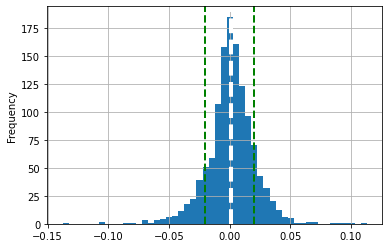

In [25]:
# histogram
aapl['LogReturn'].plot(kind='hist', bins=50, figsize=(6, 4))

# 수직선으로 평균, 표준편차 표시
plt.axvline(mu, color='w', linestyle='dashed', linewidth=4)
plt.axvline(sigma, color='g', linestyle='dashed', linewidth=2)
plt.axvline(-sigma, color='g', linestyle='dashed', linewidth=2)

plt.grid()

### 확률밀도함수(probability density function) 시각화
- 확률밀도 함수의 95% 신뢰구간 시각화

In [26]:
denApp = pd.DataFrame()
# pdf 
denApp['x'] = np.arange(aapl['LogReturn'].min() - 0.01, 
                                      aapl['LogReturn'].max() + 0.01, 0.001)
denApp['pdf'] = norm.pdf(denApp['x'], mu, sigma)
denApp.head()

,x,pdf
0,-0.147708,3.862167e-11
1,-0.146708,5.540692e-11
2,-0.145708,7.929409e-11
3,-0.144708,1.132039e-10
4,-0.143708,1.612225e-10


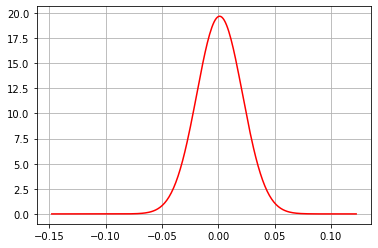

In [27]:
plt.plot(denApp['x'], denApp['pdf'], color='red')

plt.grid()

### APPL 주식이 하루에 x% 이상 하락할 확률 계산

- 누적 분포 함수(Cumulative distribution function, cdf)는 주어진 특정 값보다 작거나 같은 확률을 나타내는 함수이다.
- `norm.cdf` 함수 사용

    ex) 하루 5% 이상 하락할 확률

In [42]:
prob = norm.cdf(-0.05, mu, sigma)
print(f'평균이 {mu:.3f}이고 표준편차가 {sigma:.3f}일 때 ' + 
          f'-0.05 보다 작거나 같을 확률은 {prob * 100:.3f} % 이다.')

평균이 0.001이고 표준편차가 0.020일 때 -0.05 보다 작거나 같을 확률은 0.580 % 이다.


- 하루에 10% 이상 하락할 확률

In [47]:
prob = norm.cdf(-0.1, mu, sigma)
print('The Probability is {:.10f} %'.format(prob * 100))

The Probability is 0.0000302276 %


- 하루 1% 이상 하락할 확률

In [44]:
prob = norm.cdf(-0.01, mu, sigma)
print('The Probability is {:.10f} %'.format(prob * 100))

The Probability is 29.0716279581 %


위에서 계산한 확률을 시각화

Text(0.5, 1.0, 'Probability of Apple - 5% down a day')

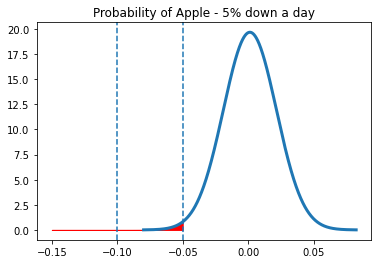

In [45]:
iq = norm(mu, sigma)
x = np.arange(mu-4*sigma, mu+4*sigma, 0.00001)

plt.plot(x, iq.pdf(x), linewidth=3)
plt.axvline(-0.05, ls='--')
plt.axvline(-0.1, ls='--')

xrange = np.arange(-0.15, -0.05, 0.0001)
plt.fill_between(xrange, y1=norm.pdf(xrange, mu, sigma), y2=0, color='red')
plt.title("Probability of Apple - 5% down a day")

### APPL 주식이 일년(220 거래일)에 xx% 이상 하락할 확률 계산

- `mu`가 daily return의 평균이므로 220 거래일의 평균 return 은 $220 \times mu $
- `sigma`가 daily return의 표준편차이므로 220 거래일의 표준편차는 $\sqrt{220} \times \sigma$

- 1년에 40% 이상 하락할 확률

In [54]:
mu220 = 220 * mu
sigma220 = (220 ** 0.5) * sigma

print('220거래일에 20% 이상 하락할 확률 {:.2f}% '.format(norm.cdf(-0.2, mu220, sigma220)*100))
print('220거래일에 40% 이상 하락할 확률 {:.2f}%'.format(norm.cdf(-0.4, mu220, sigma220)*100))

220거래일에 20% 이상 하락할 확률 6.34% 
220거래일에 40% 이상 하락할 확률 1.42%


확률 시각화

Text(0.5, 1.0, 'Probability of Apple - 20% down a year')

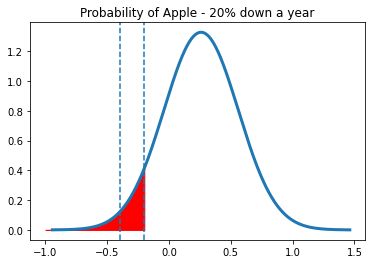

In [55]:
iq = norm(mu220, sigma220)
x = np.arange(mu220 - 4*sigma220, mu220 + 4*sigma220, 0.00001)

plt.plot(x, iq.pdf(x), linewidth=3)
plt.axvline(-0.2, ls='--')
plt.axvline(-0.4, ls='--')

xrange = np.arange(-1.0, -0.2, 0.0001)
plt.fill_between(xrange, y1=iq.pdf(xrange), y2=0, color='red')
plt.title("Probability of Apple - 20% down a year")

## Value at risk (VaR, 위험 가치) 계산

- 일일 수익률의 5% 분위수(quantile)를 95% VaR 또는 95% 수준의 VaR이라고 합니다.

    ex) 95% VAR (일일 수익률의 5% 분위수) $\rightarrow$ daily return 이 VaR 보다 더 나쁠 확률이 5% 임
    
    
- ppf : Percent point function (inverse of cdf / percentiles)   
    ppf() 함수는 주어진 정규 분포 값(sigma, mu)에 대한 확률을 계산하는 반면 cdf() 함수는 주어진 확률이 필요한 값인 정규 분포 값(sigma, mu)을 계산합니다.
    
<img src="https://i.stack.imgur.com/aZSLH.png" />
    
- VaR는 Exposure 의 크기, 변동성, 노출(exposure) 기간에 의해 영향을 받습니다.  따라서, 노출이 커지거나 변동성이 커지면 VaR 값이는 커지게 되며,   
- 최악의 상황을 정의하는 유의 수준(significance level)을 낮추면 (예를 들어, 5%를 1%로) VaR 값은 증가 합니다. 

In [63]:
print("확률이 95%가 되는 정규 분포 값 -->", norm.ppf(0.95))
print("정규분포 값 1.65의 확률 -->", norm.cdf(1.65))

확률이 95%가 되는 정규 분포 값 --> 1.6448536269514722
정규분포 값 1.65의 확률 --> 0.9505285319663519


유의 수준(신뢰 수준) 5%에서 VaR 계산

In [49]:
significance_level = 0.05
VaR = norm.ppf(significance_level, mu, sigma)

print('평균 수익률 {:.5f}, 변동성 {:.5f} 인 주식은 {}%의 확률로 daily return 이 {:.3f} 보다 나쁠 수 있다. '
          .format(mu, sigma, significance_level*100, VaR))  

평균 수익률 0.00118, 변동성 0.02028 인 주식은 5.0%의 확률로 daily return 이 -0.032 보다 나쁠 수 있다. 


In [50]:
print("평균 수익률 {:.5f}, 변동성 {:.5f} 인 주식의 daily return이 {:.3f} 보다 나쁠 확률은 {:.2f}이다."
      .format(mu, sigma, VaR, norm.cdf(VaR, mu, sigma)))

평균 수익률 0.00118, 변동성 0.02028 인 주식의 daily return이 -0.032 보다 나쁠 확률은 0.05이다.


유의 수준(신뢰 수준)을 1%로 낮추면 VaR 증가

In [51]:
significance_level = 0.01
VaR = norm.ppf(significance_level, mu, sigma)

print('평균 수익률 {:.5f}, 변동성 {:.5f} 인 주식은 {}%의 확률로 daily return 이 {:.3f} 보다 나쁠 수 있다. '
          .format(mu, sigma, significance_level*100, VaR))  

평균 수익률 0.00118, 변동성 0.02028 인 주식은 1.0%의 확률로 daily return 이 -0.046 보다 나쁠 수 있다. 
